In [6]:
from PIL import Image #PIL - biblioteca Pillow
import os #permite que o Python realize interações com o sistema operacional e gerenciamento de arquivos
import json
import time

import pickle as pkl #bibliteca para serializar (salvar) objetos python em arquivo

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image #Redimensionamento das imagens
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #one hot encoding
from sklearn.model_selection import StratifiedKFold
from keras.applications.mobilenet import preprocess_input #Pré-processamento específico da MobileNet (normalização) à imagem
from keras.applications.resnet50 import preprocess_input as resnet_preprocess_input #precisa colocar o "as" para não sobrescrever a função preprocess_input da MobileNET
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split #Separação em treino e teste

#Treinamento do modelo
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout
from keras.applications import MobileNet, ResNet50
from keras.models import Model
import keras.backend as K #suporte para diversas operações matemáticas, manipulação de tensores, etc.

#Métricas
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, classification_report, precision_score
import pickle

In [24]:
# Carregando a variável do arquivo
with open('/kaggle/input/pre-processamentoa/x_recortado_noresize.pkl', 'rb') as arquivo:
    x_orig = pickle.load(arquivo)

with open('/kaggle/input/pre-processamentoa/y_orig_mod.pkl', 'rb') as arquivo:
    y_orig = pickle.load(arquivo)
    
with open('/kaggle/input/pre-processamentoa/m_orig_mod.pkl', 'rb') as arquivo:
    m_orig = pickle.load(arquivo)

# 1 - Contrast Stretching

In [25]:
import numpy as np
from skimage import exposure

def normalizar_imagens(imagens_recortadas):
  imagens_normalizadas = []
  for imagem in imagens_recortadas:

    p5, p95 = np.percentile(imagem, (5, 95))
    imagem_normalizada = exposure.rescale_intensity(imagem, in_range=(p5, p95))

    imagens_normalizadas.append(imagem_normalizada)

  return imagens_normalizadas

In [26]:
imagens_normalizadas = normalizar_imagens(x_orig)

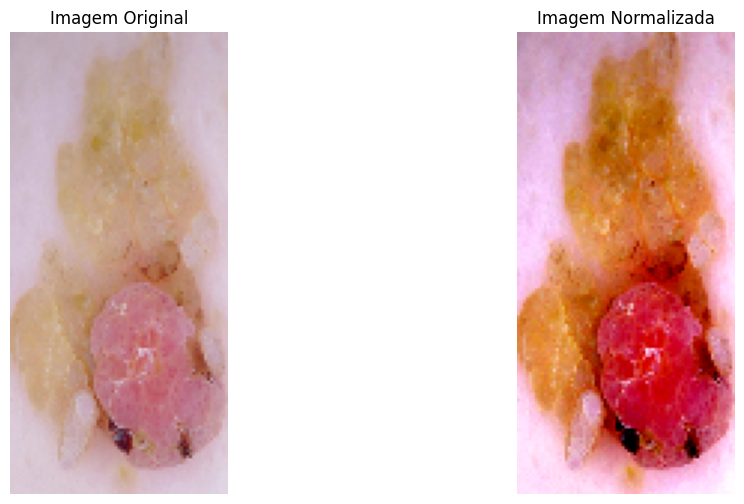

In [27]:
# Função para plotar a imagem original e a imagem normalizada
def plot_imagens(imagem_original, imagem_normalizada, indice):
    plt.figure(figsize=(12, 6))

    # Plot da imagem original
    plt.subplot(1, 2, 1)
    plt.title('Imagem Original')
    plt.imshow(imagem_original, cmap='gray')
    plt.axis('off')

    # Plot da imagem normalizada
    plt.subplot(1, 2, 2)
    plt.title('Imagem Normalizada')
    plt.imshow(imagem_normalizada, cmap='gray')
    plt.axis('off')

    plt.show()

# Plotando a primeira imagem original e a normalizada
indice_imagem = 10
plot_imagens(x_orig[indice_imagem], imagens_normalizadas[indice_imagem], indice_imagem)

# 2 - Redimensionamento para 100 x 100 proporcional 
     1° passo: escalar proporcionalmente o maior lado (altura ou largura) para 100 pixels de comprimento
     2° passo: adicionar padding circular (repetição de elementos) em ambos os lados da menor dimensão até completar 100 pixels de comprimento.

In [29]:
# Função que redimensiona as imagens presentes na "imagens_carregadas"
import numpy as np
import cv2

def redimensionar_imagens_proporcional_padding(lista_de_imagens, novo_tamanho=(100, 100)):
    imagens_redimensionadas = []

    for imagem in lista_de_imagens:
        ## 1° passo: escalar proporcionalmente o maior lado (altura ou largura) para 100 pixels de tamanho
        if len(imagem.shape) == 3:
            altura, largura, canais = imagem.shape
        else:
            altura, largura = imagem.shape
            canais = 1

        # Identificar a maior dimensão
        if altura >= largura:
            largura_redimensionada = int(np.floor((largura * novo_tamanho[0]) / altura))
            altura_redimensionada = novo_tamanho[0]
        else:
            altura_redimensionada = int(np.floor((altura * novo_tamanho[1]) / largura))
            largura_redimensionada = novo_tamanho[1]

        # Redimensionando a imagem
        imagem = imagem.astype(np.uint8)
        imagem_redimensionada = cv2.resize(imagem, (largura_redimensionada, altura_redimensionada))

        # Calculo do padding
        pad_esquerdo, pad_direito, pad_superior, pad_inferior = 0, 0, 0, 0
        if altura_redimensionada == novo_tamanho[0]:
            dif_largura = novo_tamanho[1] - largura_redimensionada
            pad_esquerdo = int(dif_largura / 2)
            pad_direito = dif_largura - pad_esquerdo
        else:
            dif_altura = novo_tamanho[0] - altura_redimensionada
            pad_superior = int(dif_altura / 2)
            pad_inferior = dif_altura - pad_superior

        # 2° passo: adicionar padding circular (repetição de elementos) em ambos os lados da menor dimensão até completar 100 pixels de tamanho.
        if canais == 1:
            imagem_com_padding = np.pad(array=imagem_redimensionada,
                                        pad_width=((pad_superior, pad_inferior), (pad_esquerdo, pad_direito)),
                                        mode='wrap')
        else:
            imagem_com_padding = np.pad(array=imagem_redimensionada,
                                        pad_width=((pad_superior, pad_inferior), (pad_esquerdo, pad_direito), (0, 0)),
                                        mode='wrap')
        
        imagens_redimensionadas.append(imagem_com_padding)

    return imagens_redimensionadas


In [30]:
# Aplicando a função nas imagens normalizadas
imagens_redimensionadas_proporcional_padding = redimensionar_imagens_proporcional_padding(imagens_normalizadas, novo_tamanho=(100, 100))

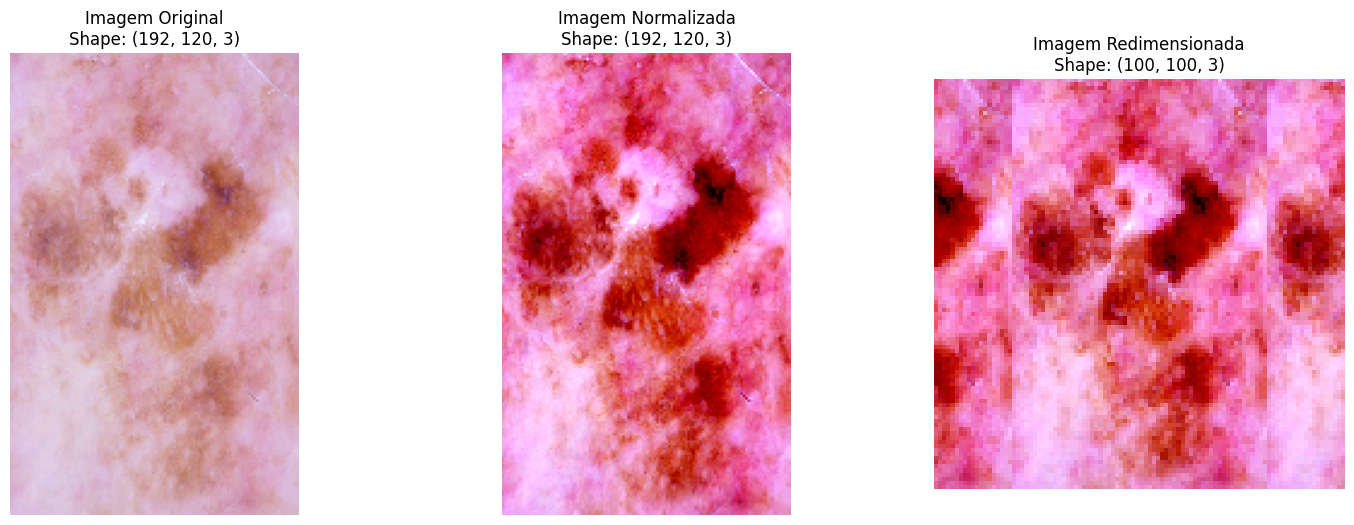

In [32]:
# Função para plotar as três imagens
def plot_imagens(imagem_original, imagem_normalizada, imagem_redimensionada, indice):
    plt.figure(figsize=(18, 6))

    # Plot da imagem original
    plt.subplot(1, 3, 1)
    plt.title(f'Imagem Original\nShape: {imagem_original.shape}')
    plt.imshow(imagem_original, cmap='gray')
    plt.axis('off')

    # Plot da imagem com contrast stretching
    plt.subplot(1, 3, 2)
    plt.title(f'Imagem Normalizada\nShape: {imagem_normalizada.shape}')
    plt.imshow(imagem_normalizada, cmap='gray')
    plt.axis('off')

    # Plot da imagem redimensionada
    plt.subplot(1, 3, 3)
    plt.title(f'Imagem Redimensionada\nShape: {imagem_redimensionada.shape}')
    plt.imshow(imagem_redimensionada, cmap='gray')
    plt.axis('off')

    plt.show()

# Plotando as três imagens para o primeiro índice
indice_imagem = 0
plot_imagens(x_orig[indice_imagem], imagens_normalizadas[indice_imagem], imagens_redimensionadas_proporcional_padding[indice_imagem], indice_imagem)

# 3 -Realizar o recorte da ROI e o processo de redimensionamento em duas etapas nas imagens contendo as máscaras

In [34]:
def extrair_bounding_boxes(mascaras):
    bounding_boxes = []
    for mascara in mascaras:
        contours, _ = cv2.findContours(mascara.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))
    return bounding_boxes

# Extraindo bounding boxes
bounding_boxes = extrair_bounding_boxes(m_orig)


In [36]:
def recortar_mascaras_com_bounding_boxes(mascaras, bounding_boxes):
    mascaras_recortadas = []
    for mascara, (x, y, w, h) in zip(mascaras, bounding_boxes):
        recorte = mascara[y:y+h, x:x+w]
        mascaras_recortadas.append(recorte)
    return mascaras_recortadas

mascaras_recortadas = recortar_mascaras_com_bounding_boxes(m_orig, bounding_boxes)

In [37]:
# Função para forçar valores próximos a zero para zero
def binarizar_mascara(mascara, limiar=1e-6):
    mascara_binarizada = np.where(mascara > limiar, 1, 0)
    return mascara_binarizada.astype(np.uint8)

# Binarizar todas as máscaras na variável mascaras_recortadas
mascaras_binarizadas = [binarizar_mascara(mascara) for mascara in mascaras_recortadas]

In [40]:
masks_redimensionadas_proporcional_padding =  redimensionar_imagens_proporcional_padding(mascaras_binarizadas, novo_tamanho=(100, 100))

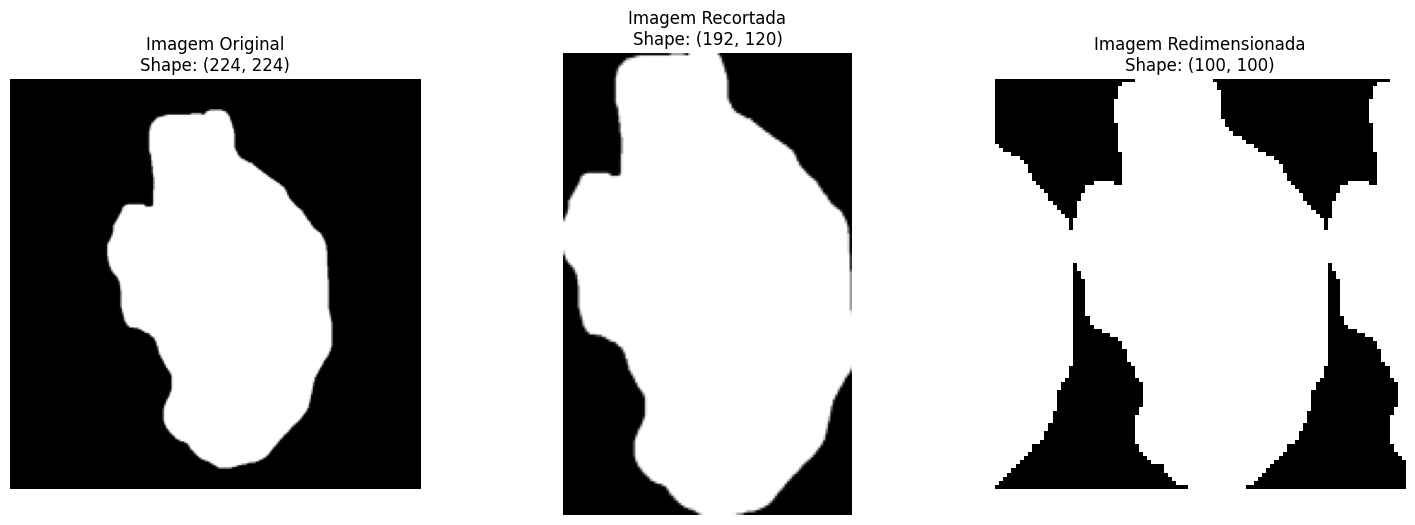

In [41]:
# Função para plotar as três imagens
def plot_imagens(imagem_original, imagem_normalizada, imagem_redimensionada, indice):
    plt.figure(figsize=(18, 6))

    # Plot da imagem original
    plt.subplot(1, 3, 1)
    plt.title(f'Imagem Original\nShape: {imagem_original.shape}')
    plt.imshow(imagem_original, cmap='gray')
    plt.axis('off')

    # Plot da imagem com contrast stretching
    plt.subplot(1, 3, 2)
    plt.title(f'Imagem Recortada\nShape: {imagem_normalizada.shape}')
    plt.imshow(imagem_normalizada, cmap='gray')
    plt.axis('off')

    # Plot da imagem redimensionada
    plt.subplot(1, 3, 3)
    plt.title(f'Imagem Redimensionada\nShape: {imagem_redimensionada.shape}')
    plt.imshow(imagem_redimensionada, cmap='gray')
    plt.axis('off')

    plt.show()

# Plotando as três imagens para o primeiro índice
indice_imagem = 0
plot_imagens(m_orig[indice_imagem], mascaras_recortadas[indice_imagem], masks_redimensionadas_proporcional_padding[indice_imagem], indice_imagem)

# 4 - Juntar máscara com imagem

In [42]:
imagens_redimensionadas_proporcional_padding = np.array(imagens_redimensionadas_proporcional_padding)

In [43]:
masks_redimensionadas_proporcional_padding = np.array(masks_redimensionadas_proporcional_padding)

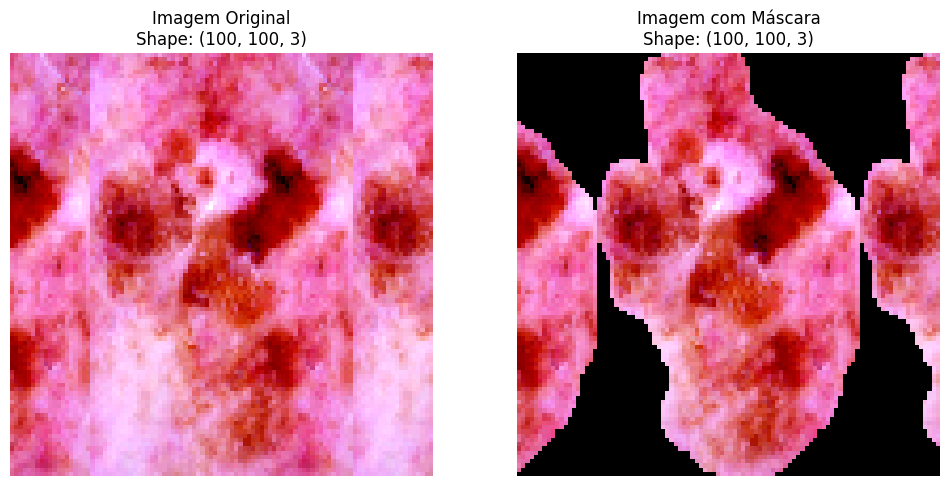

In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Função para sobrepor a máscara na imagem e preencher o resto de preto
def sobrepor_mascara_imagem(imagens, mascaras):
    imagens_sobrepostas = []
    
    for img, mask in zip(imagens, mascaras):
        # Garantir que a máscara seja binária
        mask = mask.astype(np.uint8)
        mask[mask > 0] = 1

        # Aplicar a máscara à imagem
        img_masked = cv2.bitwise_and(img, img, mask=mask)

        # Adicionar a imagem sobreposta à lista
        imagens_sobrepostas.append(img_masked)
    
    return np.array(imagens_sobrepostas)

# Supondo que imagens_redimensionadas_proporcional_padding e masks_redimensionadas_proporcional_padding
# já estejam definidas e tenham o mesmo tamanho
imagens_sobrepostas = sobrepor_mascara_imagem(imagens_redimensionadas_proporcional_padding, masks_redimensionadas_proporcional_padding)

# Função para plotar as imagens
def plot_imagem_com_mascara(imagem, imagem_sobreposta, indice):
    plt.figure(figsize=(12, 6))

    # Plot da imagem original
    plt.subplot(1, 2, 1)
    plt.title(f'Imagem Original\nShape: {imagem.shape}')
    plt.imshow(imagem)
    plt.axis('off')

    # Plot da imagem sobreposta com a máscara
    plt.subplot(1, 2, 2)
    plt.title(f'Imagem com Máscara\nShape: {imagem_sobreposta.shape}')
    plt.imshow(imagem_sobreposta)
    plt.axis('off')

    plt.show()

# Plotando as imagens para o primeiro índice
indice_imagem = 0
plot_imagem_com_mascara(imagens_redimensionadas_proporcional_padding[indice_imagem], imagens_sobrepostas[indice_imagem], indice_imagem)



In [45]:
# Definir o caminho do arquivo onde os dados serão salvos
caminho_arquivo = '/kaggle/working/x_final_completo.pkl'  # Ajuste o caminho conforme necessário

# Abrir o arquivo para escrita em modo binário e salvar o array
with open(caminho_arquivo, 'wb') as arquivo:
    pickle.dump(imagens_sobrepostas, arquivo)

print(f"Array de masks salvo em: {caminho_arquivo}")

Array de masks salvo em: /kaggle/working/x_final_completo.pkl
